In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ramanspy as rp
import os, torch

from typing import List, Tuple
from pprint import pprint
from glob import glob

from IPython.display import clear_output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [ ]:
# setup for current dir
hirushu_dir = os.getcwd() + '/Tamura/引き継ぎ/ヒルシュ'
hirushu_dir

raman_raw_dir = hirushu_dir + '/raman_raw'
hirsch_dir = {}
normal_dir = {}
other_dir = {}
for l in os.listdir(raman_raw_dir):
    if "hirsch" in l:
        hirsch_dir[l] = raman_raw_dir + '/' + l
        continue

    if "normal" in l:
        normal_dir[l] = raman_raw_dir + '/' + l
        continue
    
    other_dir[l] = raman_raw_dir + '/' + l



In [ ]:
def load_raman_data_txt(directory_path) -> pd.DataFrame:
    """
    Load all .txt Raman data files from a directory into a pandas DataFrame.
    
    Parameters:
    -----------
    directory_path : str
        Path to the directory containing Raman data files
        
    Returns:
    --------
    DataFrame with columns:
        - wavenumber: The Raman shift in cm^-1
        - Multiple columns for each sample's intensity values
    """
    # Check if directory exists
    if not os.path.exists(directory_path):
        print(f"Directory {directory_path} does not exist")
        raise FileNotFoundError(f"Directory {directory_path} does not exist")
    
    # Find all txt files in the directory
    file_paths = glob.glob(os.path.join(directory_path, "*.txt"))
    
    if not file_paths:
        print(f"No .txt files found in {directory_path}")
        raise ValueError(f"No .txt files found in {directory_path}")
    
    # Create a dictionary to store all dataframes
    data_dict = {}
    wavenumbers = None
    
    # Process each file
    for file_path in file_paths:
        # Get the filename without extension for column naming
        file_name = os.path.basename(file_path).split('.')[0]
        
        # Load data from the file
        df = pd.read_csv(file_path, sep=',', header=None, names=['wavenumber', file_name])
        
        # If this is our first file, save the wavenumbers
        if wavenumbers is None:
            wavenumbers = df['wavenumber'].values
            data_dict['wavenumber'] = wavenumbers
        
        # Store the intensity values
        data_dict[file_name] = df[file_name].values
    
    # Create a combined dataframe
    combined_df = pd.DataFrame(data_dict)
    
    print(f"Loaded {len(file_paths)} Raman spectra files")
    return combined_df



def visualize_raman_spectra(df, title="Raman Spectra", figsize=(12, 6), 
                           xlim=None, ylim=None, legend=True, 
                           legend_loc='best', sample_limit=10) -> plt:
    """
    Visualize the Raman spectra data.
    Clears any existing plots before creating a new one.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing Raman data with wavenumber column and intensity columns
    title : str
        Plot title
    figsize : tuple
        Figure size (width, height) in inches
    xlim : tuple or None
        Optional x-axis limits (min, max)
    ylim : tuple or None
        Optional y-axis limits (min, max)
    legend : bool
        Whether to display the legend
    legend_loc : str
        Legend location
    sample_limit : int
        Maximum number of samples to plot (to avoid overcrowding)
    """
    # Clear any existing plots
    plt.clf()
    plt.close('all')
    
    # Create a figure with a specific ID to reuse
    fig = plt.figure(num=1, figsize=figsize, clear=True)
    
    # Get column names except 'wavenumber'
    intensity_columns = [col for col in df.columns if col != 'wavenumber']
    
    # Limit number of samples to plot if needed
    if len(intensity_columns) > sample_limit:
        print(f"Limiting plot to {sample_limit} samples out of {len(intensity_columns)}")
        intensity_columns = intensity_columns[:sample_limit]
    
    # Plot each spectrum
    for col in intensity_columns:
        plt.plot(df['wavenumber'], df[col], label=col)
    
    # Set plot attributes
    plt.title(title)
    plt.xlabel('Raman Shift (cm⁻¹)')
    plt.ylabel('Intensity')
    plt.grid(True, alpha=0.3)
    
    if legend:
        plt.legend(loc=legend_loc, fontsize='small')
    
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    
    plt.tight_layout()
    return plt

def load_raman_data_csv(csv_filepath) -> pd.DataFrame:
    """
    Load Raman spectral data from a CSV file into a pandas DataFrame.
    
    Parameters:
    -----------
    csv_filepath : str
        Path to the CSV file containing Raman spectral data
        
    Returns:
    --------
    DataFrame with columns:
        - wavenumber: The Raman shift in cm^-1
        - Multiple columns for each sample's intensity values
    """
    # Check if file exists
    if not os.path.exists(csv_filepath):
        print(f"File {csv_filepath} does not exist")
        raise FileNotFoundError(f"File {csv_filepath} does not exist")
    
    # Load data
    try:
        # Read CSV file - header is in row 0
        df = pd.read_csv(csv_filepath, header=0)
        
        # Set the first column as the wavenumber column
        wavenumber_col = df.columns[0]
        df = df.rename(columns={wavenumber_col: 'wavenumber'})
        
        # Check if data has expected structure
        if len(df.columns) < 2:
            raise ValueError(f"CSV file {csv_filepath} does not contain enough columns")
        
        print(f"Loaded Raman spectra with {len(df.columns)-1} samples and {len(df)} data points")
        return df
        
    except Exception as e:
        print(f"Error loading CSV file: {e}")
        raise
   
   
    
def add_gaussian_noise(spectrum: pd.DataFrame, noise_level=0.01) -> pd.DataFrame:
    noisy_df = spectrum.copy()
    # Add noise only to numeric columns except 'wavenumber'
    for col in noisy_df.columns:
        if col != 'wavenumber' and np.issubdtype(noisy_df[col].dtype, np.number):
            noise = np.random.normal(loc=0.0, scale=noise_level, size=noisy_df[col].shape)
            noisy_df[col] = noisy_df[col] + noise
    return noisy_df

def normalize_spectrum(spectrum: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize the intensity values of the Raman spectrum.
    
    Parameters:
    -----------
    spectrum : pandas DataFrame
        DataFrame containing Raman data with wavenumber column and intensity columns
        
    Returns:
    --------
    DataFrame with normalized intensity values
    """
    # Create a copy to avoid modifying the original DataFrame
    normalized_df = spectrum.copy()
    
    # Normalize all columns except 'wavenumber'
    for col in normalized_df.columns:
        if col != 'wavenumber':
            normalized_df[col] = (normalized_df[col] - normalized_df[col].min()) / (normalized_df[col].max() - normalized_df[col].min())
    
    return normalized_df

def auto_detect_baseline_region(df, window_size=50):
    """
    Automatically detect flat (low-variance) region in the Raman spectrum.
    Uses a sliding window over the wavenumber axis.
    """
    wavenumber = df['wavenumber'].values
    spectra = df.drop('wavenumber', axis=1).values

    min_std = np.inf
    min_idx = 0
    
    # Scan through the spectrum using a moving window
    for i in range(0, len(wavenumber) - window_size):
        segment = spectra[i:i+window_size, :]
        segment_std = np.std(segment)
        
        if segment_std < min_std:
            min_std = segment_std
            min_idx = i
    
    # Extract the best baseline region
    start_wn = wavenumber[min_idx]
    end_wn = wavenumber[min_idx + window_size - 1]
    
    print(f"Auto-detected baseline region: {start_wn:.2f}–{end_wn:.2f} cm⁻¹")

    # Return the sliced baseline DataFrame
    baseline_df = df[(df['wavenumber'] >= start_wn) & (df['wavenumber'] <= end_wn)]
    return baseline_df





Loaded Raman spectra with 20 samples and 858 data points
min_wn: 1100.0581, max_wn: 1787.8837
Auto-detected baseline region: 1752.46–1787.18 cm⁻¹
Baseline noise std calculated: 18.4647


<module 'matplotlib.pyplot' from '/home/zerozed/ai-env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

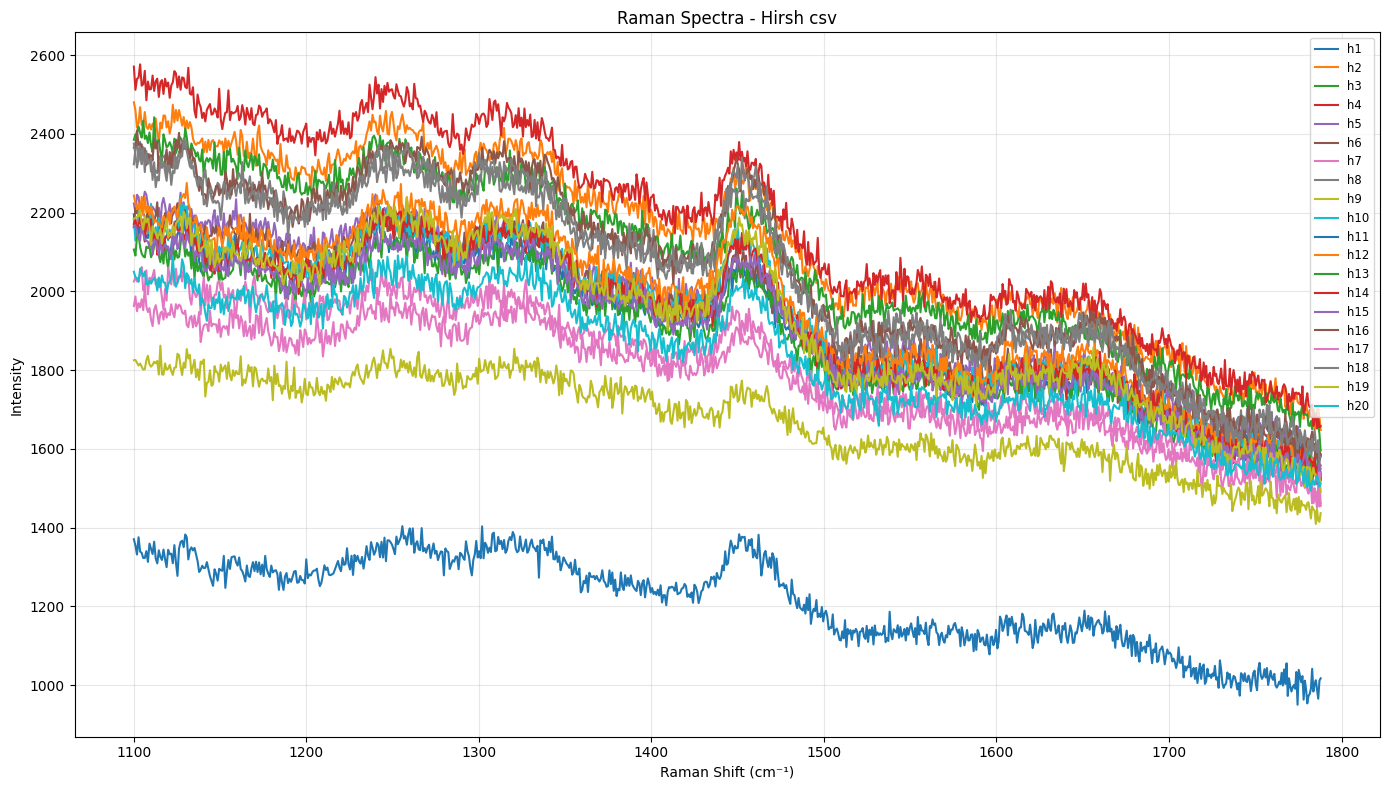

In [12]:
rawdata_dir = os.path.join(hirushu_dir, 'データ', 'merged_data_raw', 'Case1', 'hirsch', 'hirsch.csv')
raman_df = load_raman_data_csv(rawdata_dir)
# Visualize the data (reuses the same figure)
# Check wavenumber range
print(f"min_wn: {raman_df['wavenumber'].min()}, max_wn: {raman_df['wavenumber'].max()}")
baseline_df = auto_detect_baseline_region(raman_df, window_size=50)
noise_std = baseline_df.drop('wavenumber', axis=1).std().mean()
print(f"Baseline noise std calculated: {noise_std:.4f}")
# add noise to the original data to simulate real-world conditions
raman_df = add_gaussian_noise(raman_df, noise_level=noise_std)
wavenumbers = raman_df['wavenumber'].values
intensities = raman_df.drop('wavenumber', axis=1).values.T  # Transpose here!

visualize_raman_spectra(raman_df, title="Raman Spectra - Hirsh csv",
                        figsize=(14, 8), legend_loc='upper right', sample_limit=20)

In [13]:
def pipeline_hirschsprung_multi(
    hirsch_dfs: List[pd.DataFrame], 
    normal_dfs: List[pd.DataFrame],
    region: Tuple[int, int] = (1050, 1700)
) -> Tuple[np.ndarray, list, np.ndarray, pd.DataFrame]:
    """
    Preprocessing pipeline for multiple Hirshsprung disease and normal Raman DataFrames.
    Returns: processed_data (n_samples, n_features), labels (list), wavenumbers (np.ndarray)
    """
    # Handle empty input cases
    if not hirsch_dfs and not normal_dfs:
        raise ValueError("Both hirsch_dfs and normal_dfs are empty. At least one must be provided.")
    elif hirsch_dfs:
        wavenumbers = hirsch_dfs[0]['wavenumber'].values
    else:
        wavenumbers = normal_dfs[0]['wavenumber'].values

    # Concatenate all hirsch and normal DataFrames (drop wavenumber, keep only intensity columns)
    all_hirsch = [df.drop('wavenumber', axis=1) for df in hirsch_dfs] if hirsch_dfs else []
    all_normal = [df.drop('wavenumber', axis=1) for df in normal_dfs] if normal_dfs else []
    merged_df = pd.concat(all_hirsch + all_normal, axis=1)

    intensities = merged_df.values.T  # shape: (n_samples, n_wavenumbers)

    # Labels
    labels = []
    if hirsch_dfs:
        labels += ['hirsch'] * sum(df.shape[1] - 1 for df in hirsch_dfs)
    if normal_dfs:
        labels += ['normal'] * sum(df.shape[1] - 1 for df in normal_dfs)

    # Preprocessing pipeline
    pipeline = rp.preprocessing.Pipeline([
        rp.preprocessing.misc.Cropper(region=region),
        rp.preprocessing.despike.WhitakerHayes(),
        rp.preprocessing.denoise.SavGol(window_length=7, polyorder=3),
        rp.preprocessing.baseline.ASPLS(lam=1e5, tol=0.01),
        rp.preprocessing.normalise.Vector()
    ])
    spectra = rp.SpectralContainer(intensities, wavenumbers)
    data = pipeline.apply(spectra)

    # Return processed data, labels, and wavenumbers for further analysis
    return data.spectral_data, labels, data.spectral_axis, merged_df



In [14]:
def baselineAndGaussianNoise(df, window_size=50):
    """
    Detect baseline and add Gaussian noise to the DataFrame.
    """
    # Detect baseline region
    baseline_df = auto_detect_baseline_region(df, window_size=window_size)
    
    # Calculate noise standard deviation
    noise_std = baseline_df.drop('wavenumber', axis=1).std().mean()
    
    # Add Gaussian noise
    noisy_df = add_gaussian_noise(df, noise_level=noise_std)
    
    return noisy_df


hirsch_dfs = []
m = 2
n = 1
window_size = 50
for k in range(1, 4):
    if k == m:
        continue
    
    hirsch_dfs.append(baselineAndGaussianNoise(load_raman_data_csv(os.path.join(hirushu_dir, 'データ', 
                                                 'merged_data_raw', 
                                                 f'Case{k}', 
                                                 'hirsch', f'hirsch.csv')), window_size=window_size))
    
normal_dfs = []
for k in range(1, 4):
    if k == n:
        continue
    
    normal_dfs.append(baselineAndGaussianNoise(load_raman_data_csv(os.path.join(hirushu_dir, 'データ',
                                                 'merged_data_raw', 
                                                 f'Case{k}', 
                                                 'normal', f'normal.csv')), window_size=window_size))
    
test_hirsch_df = baselineAndGaussianNoise(load_raman_data_csv(os.path.join(hirushu_dir, 'データ', 
                                                 'merged_data_raw', 
                                                 f'Case{m}', 
                                                 'hirsch', f'hirsch.csv')), window_size=window_size)

test_normal_df = baselineAndGaussianNoise(load_raman_data_csv(os.path.join(hirushu_dir, 'データ', 
                                                 'merged_data_raw', 
                                                 f'Case{n}', 
                                                 'normal', f'normal.csv')), window_size=window_size)




Loaded Raman spectra with 20 samples and 858 data points
Auto-detected baseline region: 1752.46–1787.18 cm⁻¹
Loaded Raman spectra with 40 samples and 858 data points
Auto-detected baseline region: 1752.46–1787.18 cm⁻¹
Loaded Raman spectra with 50 samples and 858 data points
Auto-detected baseline region: 1752.46–1787.18 cm⁻¹
Loaded Raman spectra with 40 samples and 858 data points
Auto-detected baseline region: 1752.46–1787.18 cm⁻¹
Loaded Raman spectra with 20 samples and 858 data points
Auto-detected baseline region: 1752.46–1787.18 cm⁻¹
Loaded Raman spectra with 20 samples and 858 data points
Auto-detected baseline region: 1752.46–1787.18 cm⁻¹


In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

print(rawdata_dir)
# Ensure 'data' is your preprocessed SpectralContainer from ramanspy
# The spectral data is stored in data.spectral_data (shape: n_samples, n_wavenumbers)
spectral_data_matrix = data.spectral_data

# 1. Apply PCA
# PCA (Principal Component Analysis) is a technique to reduce the dimensionality of the data
# Determine optimal number of components using explained variance
pca_full = PCA().fit(spectral_data_matrix)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), 'o-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.legend()
plt.show()

# 2. Choose components to reach 95% explained variance
variance_threshold = 0.95
n_components_95 = np.argmax(np.cumsum(pca_full.explained_variance_ratio_) >= variance_threshold) + 1
print(f"Number of components needed for {variance_threshold*100}% variance: {n_components_95}")

# 3. Apply PCA with this optimal number
pca_optimal = PCA(n_components=n_components_95)
pca_result_optimal = pca_optimal.fit_transform(spectral_data_matrix)

# 4. Apply k-means on the optimal PCA results
n_clusters = 2  # Define number of clusters as a variable
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(pca_result_optimal)

print(f"\nCluster labels assigned by k-means: {cluster_labels}")

# 5. Create a 2D PCA for visualization purposes only
pca_viz = PCA(n_components=2).fit(spectral_data_matrix)
pca_result_viz = pca_viz.transform(spectral_data_matrix)

# 6. Visualize the clusters in 2D PCA space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_result_viz[:, 0], pca_result_viz[:, 1], 
                     c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title('PCA of Raman Spectra with k-means Clusters')
plt.xlabel(f'Principal Component 1 ({pca_viz.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pca_viz.explained_variance_ratio_[1]*100:.2f}%)')
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {i}' for i in range(n_clusters)])
plt.grid(True, alpha=0.3)
plt.show()

# 7. Analyze cluster characteristics (e.g., plot mean spectra per cluster)
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    cluster_spectra = spectral_data_matrix[cluster_labels == i]
    mean_spectrum = cluster_spectra.mean(axis=0)
    plt.plot(data.spectral_axis, mean_spectrum, label=f'Cluster {i} Mean Spectrum')

plt.title('Mean Raman Spectra per k-means Cluster')
plt.xlabel('Raman Shift (cm⁻¹)')
plt.ylabel('Intensity (Processed)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Use processed_data for PCA and clustering
X_reduced = PCA(n_components=2).fit_transform(processed_data)

kmeans = KMeans(n_clusters=2, random_state=0).fit(X_reduced)
cluster_labels = kmeans.labels_

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

print(confusion_matrix(labels_encoded, cluster_labels))
print(classification_report(labels_encoded, cluster_labels, target_names=le.classes_))



In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Target specific biological components
regions = [
    (100, 3000),     # Full range (if available)
    (700, 1800),      # Full fingerprint region
    (800, 1300),      # CH stretch to Amide I
    (950, 1700),      # Collagen to Amide I
    (1000, 1700),     # Phenylalanine to Amide I
    (1200, 1700),     # Amide III to Amide I
    (1000, 1380),     # Phenylalanine to Lipid/protein
    (1300, 1700),     # Lipid/protein to Amide I
    (1550, 1700),     # Amide I
    (1000, 3000),     # Fingerprint + CH stretch (if available)
    
]

best_data = {"region": None, 
             "best_params": None, 
             "confusion_matrix": None,
             "classification_report": None,
             "score": None}

for r in regions:
    try:
        processed_data, labels, wavenumbers, _ = pipeline_hirschsprung_multi(hirsch_dfs, normal_dfs, r)

        param_grid = {
            'C': [0.01, 0.1, 1, 10, 100],
            'gamma': ['scale', 0.01, 0.1, 1, 10],
            'kernel': ['rbf', 'linear'],
        }
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=cv)

        X_train, X_test, y_train, y_test = train_test_split(
            processed_data, labels, test_size=0.3, stratify=labels, random_state=42
        )

        grid.fit(X_train, y_train)
        

        clf = SVC(kernel=grid.best_params_["kernel"], 
                C=grid.best_params_["C"], 
                gamma=grid.best_params_["gamma"], 
                probability=True, 
                class_weight='balanced')
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        confs_matrix = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        try:
            acc_score = np.mean(np.array(y_test) == np.array(y_pred))
        except Exception as e:
            print(f"Error calculating accuracy score: {e}")
            acc_score = 0
            
        print(grid.best_params_, f"accuracy: {acc_score:.4f}")
        if best_data["score"] is None or grid.best_score_ > best_data["score"]:
            best_data["region"] = r
            best_data["best_params"] = grid.best_params_
            best_data["confusion_matrix"] = confs_matrix
            best_data["classification_report"] = report
            best_data["accuracy_score"] = acc_score.__round__(4)
            best_data["score"] = grid.best_score_
    except Exception as e:
        print(f"Error processing region {r}: {e}")
        continue
        
clear_output()
pprint(best_data, indent=1)
pprint(best_data["classification_report"])   

{'accuracy_score': 0.6889,
 'best_params': {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'},
 'classification_report': '              precision    recall  f1-score   '
                          'support\n'
                          '\n'
                          '      hirsch       0.60      0.67      0.63        '
                          '18\n'
                          '      normal       0.76      0.70      0.73        '
                          '27\n'
                          '\n'
                          '    accuracy                           0.69        '
                          '45\n'
                          '   macro avg       0.68      0.69      0.68        '
                          '45\n'
                          'weighted avg       0.70      0.69      0.69        '
                          '45\n',
 'confusion_matrix': array([[12,  6],
       [ 8, 19]]),
 'region': (1000, 1380),
 'score': 0.7363636363636364}
('              precision    recall  f1-score   support\n'


In [17]:
# ✅ Correct way: TRAIN on merged Case1+2 data, TEST on Case3
train_data, train_labels, _, _ = pipeline_hirschsprung_multi(hirsch_dfs, normal_dfs, region=best_data["region"])
test_data, test_labels, _, _ = pipeline_hirschsprung_multi(hirsch_dfs=[test_hirsch_df], normal_dfs=[test_normal_df], region=best_data["region"])

# Retrain classifier on full training data
clf = SVC(kernel=best_data["best_params"]["kernel"],
          C=best_data["best_params"]["C"],
          gamma=best_data["best_params"]["gamma"],
          probability=True,
          class_weight='balanced')
clf.fit(train_data, train_labels)

# ✅ Predict on new patient
y_test_pred = clf.predict(test_data)

# Evaluate
print(confusion_matrix(test_labels, y_test_pred))
print(classification_report(test_labels, y_test_pred))
print("CLF SCORE:", clf.score(test_data, test_labels))

[[ 9 11]
 [16  4]]
              precision    recall  f1-score   support

      hirsch       0.36      0.45      0.40        20
      normal       0.27      0.20      0.23        20

    accuracy                           0.33        40
   macro avg       0.31      0.33      0.31        40
weighted avg       0.31      0.33      0.31        40

CLF SCORE: 0.325


In [31]:
def loadAllCellsRamanSpectraKaggle1(dir_path: str) -> dict:
    """
    Load all .csv Raman data files from a directory into a dictionary of DataFrames.
    
    dir_path : str
        Path to the directory containing Raman data folders, as the dataset is organized in folders.
    
    get data from:
    https://www.kaggle.com/datasets/andriitrelin/cells-raman-spectra
    
    +---------------------+-------+----------------------------------------+-----------------+---------------+---------------+
    | Label of the sample | cells | characterization                       | origin          | Serum content | No of samples |
    +---------------------+-------+----------------------------------------+-----------------+---------------+---------------+
    | A                   | A2058 | melanoma cells                         | Cell line       | 10.00%        | 9             |
    +---------------------+-------+----------------------------------------+-----------------+---------------+---------------+
    | A-S                 | A2058 | melanoma cells                         | Cell line       | 0.00%         | 9             |
    +---------------------+-------+----------------------------------------+-----------------+---------------+---------------+
    | G                   | G361  | melanoma cells                         | Cell line       | 10.00%        | 9             |
    +---------------------+-------+----------------------------------------+-----------------+---------------+---------------+
    | G-S                 | G361  | melanoma cells                         | Cell line       | 0.00%         | 8             |
    +---------------------+-------+----------------------------------------+-----------------+---------------+---------------+
    | HPM                 | HPM   | neonatal highly pigmented  melanocytes | Cell line       | 10.00%        | 9             |
    +---------------------+-------+----------------------------------------+-----------------+---------------+---------------+
    | HPM-S               | HPM   | neonatal highly pigmented  melanocytes | Cell line       | 0.00%         | 9             |
    +---------------------+-------+----------------------------------------+-----------------+---------------+---------------+
    | HF                  | HF    | normal skin fibroblasts                | Primary culture | 10.00%        | 9             |
    +---------------------+-------+----------------------------------------+-----------------+---------------+---------------+
    | HF-S                | HF    | normal skin fibroblasts                | Primary culture | 0.00%         | 9             |
    +---------------------+-------+----------------------------------------+-----------------+---------------+---------------+
    | ZAM                 | ZAM   | tumour associated fibroblasts          | Primary culture | 10.00%        | 9             |
    +---------------------+-------+----------------------------------------+-----------------+---------------+---------------+
    | ZAM-S               | ZAM   | tumour associated fibroblasts          | Primary culture | 0.00%         | 9             |
    +---------------------+-------+----------------------------------------+-----------------+---------------+---------------+
    | DMEM                | None  | pure medium - control                  |                 | 10.00%        | 8             |
    +---------------------+-------+----------------------------------------+-----------------+---------------+---------------+
    | DMEM-S              | None  | pure medium - control                  |                 | 0.00%         | 9             |
    +---------------------+-------+----------------------------------------+-----------------+---------------+---------------+

    EACH FOLDER(LABEL) CONTAIN
    - (COOH)2.csv
    - COOH.csv
    - NH2.csv
    
    set wavenumber for this dataset as it not included together: 
    wavenumber = np.linspace(100, 4278, 2090)
    """
    
    data_dict = {}
    wavenumbers = np.linspace(100, 4278, 2090)

    if not os.path.exists(dir_path):
        print(f"Directory {dir_path} does not exist")
        raise FileNotFoundError(f"Directory {dir_path} does not exist")

    for folder in os.listdir(dir_path):
        folder_path = os.path.join(dir_path, folder)
        if not os.path.isdir(folder_path):
            continue

        sample_dict = {}
        for file in os.listdir(folder_path):
            if file.endswith(".csv"):
                sample_type = os.path.splitext(file)[0]  # e.g., "(COOH)2", "COOH", "NH2"
                df = load_raman_data_csv(os.path.join(folder_path, file))
                sample_dict[sample_type] = df

        if sample_dict:
            data_dict[folder] = sample_dict

    return data_dict
    
    
test_rawdata_dir = os.getcwd() + '/test_rawdata'
testCellsRamanSpectra_dir = os.path.join(test_rawdata_dir, 'cells-raman-spectra')
allCellsData =loadAllCellsRamanSpectraKaggle1(testCellsRamanSpectra_dir)
clear_output()


In [ ]:
visualize_raman_spectra(allCellsData["A"]["(COOH)2"], title="Raman Spectra - A (COOH)2",
                        figsize=(14, 8), legend_loc='upper right', sample_limit=20)

,wavenumber,1,2,3,4,5,6,7,8,9,...,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089
0,77.374046,75.621507,74.827457,61.264341,40.528815,39.432864,44.749402,47.503784,48.907394,27.498272,...,0.000664,0.000545,0.000426,0.000308,0.000189,0.000070,-0.000049,-0.000168,-0.000287,-0.000405
1,88.081757,113.156798,105.854388,79.869821,64.849549,54.186113,49.262768,45.522822,35.178623,29.644172,...,0.000933,0.000771,0.000609,0.000447,0.000286,0.000124,-0.000038,-0.000199,-0.000361,-0.000522
2,61.157782,76.724459,76.431511,70.389519,68.768628,54.645471,35.151602,20.716670,14.441216,15.043942,...,0.000533,0.000428,0.000322,0.000217,0.000111,0.000006,-0.000099,-0.000205,-0.000310,-0.000415
3,25.682363,28.009787,25.439136,23.391549,23.497388,16.403860,11.542105,13.032593,13.465638,8.640664,...,0.000213,0.000175,0.000137,0.000099,0.000061,0.000023,-0.000015,-0.000053,-0.000091,-0.000129
4,36.548754,50.955488,49.968908,43.540421,43.091401,32.390871,12.458096,-2.237221,-0.164592,2.146683,...,0.000550,0.000463,0.000376,0.000289,0.000202,0.000115,0.000028,-0.000060,-0.000147,-0.000234
5,93.759762,120.916966,116.982364,91.448609,74.985592,60.475104,51.892195,52.942863,57.100680,44.905130,...,0.000992,0.000815,0.000639,0.000463,0.000287,0.000111,-0.000065,-0.000241,-0.000417,-0.000593
6,34.713401,38.091662,37.184032,31.850853,28.097487,30.962981,29.318169,20.785343,14.630108,11.283101,...,0.000404,0.000333,0.000262,0.000192,0.000121,0.000050,-0.000020,-0.000091,-0.000161,-0.000232
7,102.364120,122.241494,120.629600,106.415622,98.000893,76.868279,63.082665,67.285103,70.690854,43.585489,...,0.000503,0.000401,0.000298,0.000196,0.000094,-0.000009,-0.000111,-0.000213,-0.000315,-0.000417
8,37.021667,42.738126,46.433341,43.386845,31.796380,19.223939,15.359445,18.510981,18.105770,13.402574,...,0.000369,0.000303,0.000238,0.000172,0.000107,0.000041,-0.000024,-0.000089,-0.000155,-0.000220
9,30.977649,23.586866,23.311070,27.838610,25.930221,18.696854,10.670600,7.251347,9.206045,4.734020,...,0.000282,0.000236,0.000190,0.000144,0.000098,0.000052,0.000006,-0.000040,-0.000086,-0.000132
